In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [2]:
tickers=['SPY', 'BND', 'GLD', 'QQQ', 'VTI', 'BTC']

In [3]:
end_date=datetime.today()

In [4]:
start_date=end_date-timedelta(days=5*365)
print(start_date)

2020-08-04 08:12:55.526818


In [5]:
adj_close_df=pd.DataFrame()

In [6]:
for ticker in tickers:
    data=yf.download(ticker, auto_adjust=False, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI  \
Date                                                                    
2020-08-04  307.324829  77.300972  189.589996  262.551056  155.813217   
2020-08-05  309.233673  77.197250  191.350006  263.201691  156.947266   
2020-08-06  311.300690  77.318237  193.889999  266.687775  157.709518   
2020-08-07  311.524261  77.231834  190.809998  263.609589  157.839645   
2020-08-10  312.455383  77.145462  190.149994  262.483063  158.276581   
...                ...        ...         ...         ...         ...   
2025-07-28  636.940002  72.758659  305.410004  568.140015  313.600006   
2025-07-29  635.260010  73.137398  306.250000  567.260010  312.609985   
2025-07-30  634.460022  72.948036  300.959991  568.020020  312.250000   
2025-07-31  632.080017  72.957993  302.959991  565.010010  310.890015   
2025-08-01  621.719971  73.589996  309.109985  553.880005  305.739990   

                  BTC  
Date                   
20

In [8]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [9]:
log_returns = log_returns.dropna()

In [10]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI       BTC
SPY  0.040420  0.000453  0.001766  0.047975  0.040410  0.045294
BND  0.000453  0.002703  0.001568 -0.000089  0.000435 -0.000747
GLD  0.001766  0.001568  0.031098  0.002510  0.001637  0.007804
QQQ  0.047975 -0.000089  0.002510  0.060592  0.047941  0.057565
VTI  0.040410  0.000435  0.001637  0.047941  0.040560  0.047216
BTC  0.045294 -0.000747  0.007804  0.057565  0.047216  0.252573


In [11]:
def standard_deviation (weights, cov_matrix):
    variance= weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [12]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [13]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [14]:
risk_free_rate = 0.02

In [15]:
def neg_sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate)

In [16]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

In [17]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


In [18]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [19]:
optimal_weights = optimized_results.x

In [20]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight: .4f}")
print()

optimal_portfolio_returns = expected_return(optimal_weights, log_returns)
optimal_porfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_Sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected  Annual Return: {optimal_portfolio_returns:.4f}")
print(f"Expected Volatility: {optimal_porfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_Sharpe_ratio:.4f}")

Optimal Weights:
SPY:  0.0000
BND:  0.3629
GLD:  0.5000
QQQ:  0.0323
VTI:  0.0000
BTC:  0.1047

Expected  Annual Return: 0.2343
Expected Volatility: 0.1130
Sharpe Ratio: 1.8966


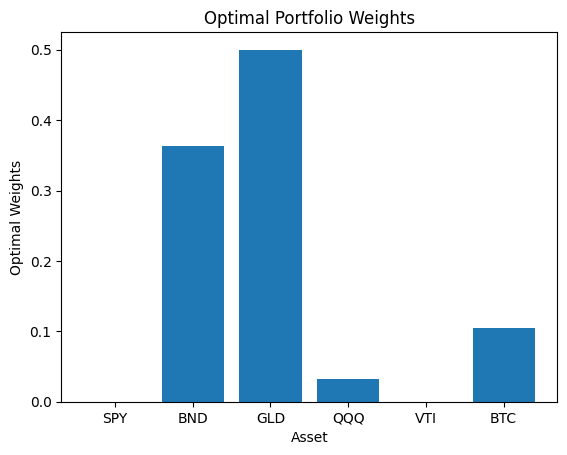

In [21]:
import matplotlib.pyplot as plot
plot.Figure(figsize=(10, 6))
plot.bar(tickers, optimal_weights)

plot.xlabel("Asset")
plot.ylabel("Optimal Weights")
plot.title("Optimal Portfolio Weights")
plot.show()